In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import json
import sys


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from joblib import dump, load

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
proj_dir = Path('../../..')

geopackage_fn = proj_dir / 'data/gis/geopackages/columbia_river_basin.gpkg'
# landsat_data_fn = proj_dir / 'data/landsat/columbia_clean.csv'
landsat_data_fn = proj_dir / 'data/landsat/crb_landsat.csv'
insitu_data_dir = proj_dir / 'data/insitu/conditions/processed'


In [5]:
# check the layers in the geopackage
import fiona
layers = fiona.listlayers(geopackage_fn)
print(layers)

['Basins', 'Dams', 'Reservoirs', 'fish_stations', 'FilteredReaches', 'Rivers', 'Stations', 'TempLocationsInBuffer', 'good2_dams', 'Reaches', 'BufferedReaches', 'GOOD2_dams_with_RKm']


In [4]:
package_dir = proj_dir / '../01-THORR/src/THORR'

utils = str(package_dir / 'utils')
sys.path.insert(0, utils)
from sql import connect # utility functions for connecting to MySQL

In [5]:
# Create a connection object to the MySQL database
# conn = connect.Connect(str(proj_dir / "Methods/2.Data/DBManagement/mysql_config.ini"))
conn = connect.Connect(str(proj_dir / ".env/mysql_config.ini"))
connection = conn.conn

Connecting to MySQL database...
MySQL connection established.


In [6]:
buffered_reaches = gpd.read_file(geopackage_fn, layer='BufferedReaches')
stations = gpd.read_file(geopackage_fn, layer='Stations')
basin = gpd.read_file(geopackage_fn, layer='Basins')

<Axes: >

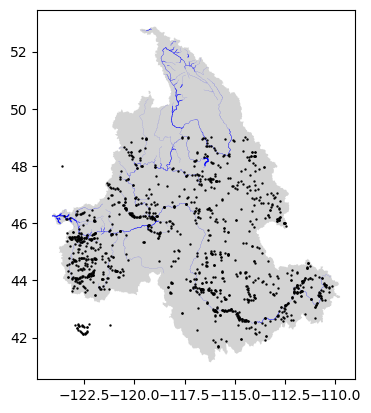

In [7]:
fig, ax = plt.subplots()
basin.plot(ax=ax, color='lightgray')
buffered_reaches.plot(ax=ax, color='blue')
stations.plot(ax=ax, color='black', markersize=0.5)

In [8]:
# use lambda to filter stations with fish data
temp_locations = stations[stations['available_data'].apply(lambda x: 'conditions' in json.loads(x))]
temp_locations = temp_locations[temp_locations['available_data'].apply(lambda x: 'avg_temp(C)' in json.loads(x)['conditions'])]
# find the temp locations in the basin
# temp_locations = temp_locations[temp_locations.within(basin.geometry.iloc[0])].copy()

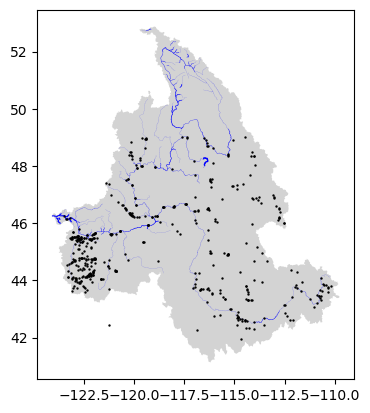

In [9]:
# plot temperature locations
fig, ax = plt.subplots()
basin.plot(ax=ax, color='lightgray')
buffered_reaches.plot(ax=ax, color='blue')
temp_locations.plot(ax=ax, color='black', markersize=0.5);

In [10]:
temp_locs_in_buffer = temp_locations[temp_locations.within(buffered_reaches.unary_union)].copy()
temp_locs_in_buffer

,station_ID,id_at_source,available_data,source_URL,latitude,longitude,description,site_params,geometry
0,DART_ALF,ALF,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",48.178294,-116.997745,Albeni Falls Forebay and Dam,{},POINT (-116.99774 48.17829)
1,DART_BON,BON,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",45.644167,-121.940556,Bonneville Forebay and Dam,{},POINT (-121.94056 45.64417)
2,DART_CCIW,CCIW,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",45.648503,-121.940663,Cascade Island (below BON),{},POINT (-121.94066 45.64850)
3,DART_CHJ,CHJ,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",47.995278,-119.633333,Chief Joseph Forebay and Dam,{},POINT (-119.63333 47.99528)
4,DART_CHQW,CHQW,"{""conditions"": [""outflow(m3/d)"", ""inflow(m3/d)...","{""url"": [""https://www.cbr.washington.edu/dart/...",47.995278,-119.633333,Chief Joseph Tailrace,{},POINT (-119.63333 47.99528)
...,...,...,...,...,...,...,...,...,...
857,USGS_14128910,14128910,"{""conditions"": [""max_temp(C)"", ""min_temp(C)"", ...","{""url"": [""https://waterdata.usgs.gov/monitorin...",45.612340,-122.027584,"COLUMBIA RIVER AT WARRENDALE, OR",{},POINT (-122.02758 45.61234)
869,USGS_14171750,14171750,"{""conditions"": [""max_temp(C)"", ""min_temp(C)"", ...","{""url"": [""https://waterdata.usgs.gov/monitorin...",44.641511,-123.117873,"WILLAMETTE R AB CALAPOOIA R AT ALBANY,OREG.",{},POINT (-123.11787 44.64151)
878,USGS_14191000,14191000,"{""conditions"": [""max_temp(C)"", ""min_temp(C)"", ...","{""url"": [""https://waterdata.usgs.gov/monitorin...",44.944286,-123.042874,"WILLAMETTE RIVER AT SALEM, OR",{},POINT (-123.04287 44.94429)
903,USGS_453606121101000,453606121101000,"{""conditions"": [""max_temp(C)"", ""min_temp(C)"", ...","{""url"": [""https://waterdata.usgs.gov/monitorin...",45.601509,-121.170626,"COLUMBIA RIVER, LEFT BANK, NEAR THE DALLES, OR",{},POINT (-121.17063 45.60151)


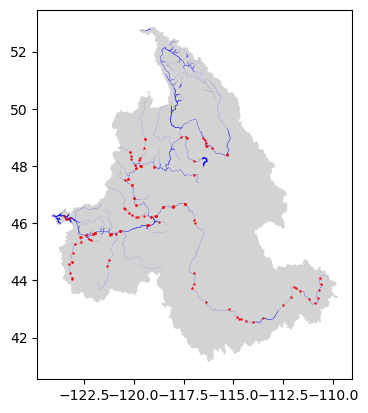

In [11]:
# filter temperature locations within the buffered
fig, ax = plt.subplots()
basin.plot(ax=ax, color='lightgray')
buffered_reaches.plot(ax=ax, color='blue')
temp_locs_in_buffer.plot(ax=ax, color='red', markersize=0.5);

In [12]:
buffered_reaches.columns

Index(['GNIS_Name', 'reach_id', 'RKm', 'OBJECTID', 'ID', 'WidthMin',
       'width_med_', 'WidthMean', 'WidthMax', 'width_sd_m', 'lakeFlag',
       'nSegPx', 'Shape_Leng', 'distance', 'DistToUpDam', 'DistToDownDam',
       'UpDamGrandID', 'DownDamGrandID', 'koppen', 'geometry'],
      dtype='object')

In [13]:
buffered_reaches.drop(columns=[col for col in buffered_reaches.columns if col in ['index_right', 'index_left']], inplace=True)
temp_locs_in_buffer.drop(columns=[col for col in temp_locs_in_buffer.columns if col in ['index_right', 'index_left']], inplace=True)

temp_locs_in_buffer = temp_locs_in_buffer.sjoin(buffered_reaches, how='left', predicate='within')
# temp_locs_in_buffer.head()

In [14]:
# # show duplicates in temp_locs_in_buffer
# temp_locs_in_buffer[temp_locs_in_buffer.duplicated(subset='station_ID', keep=False)][['station_ID', 'RKm']]

# drop duplicates
# temp_locs_in_buffer.drop_duplicates(subset='station_ID', inplace=True)

In [15]:
# # retrieve the landsat data from from the MySQL database
# query = """
# SELECT 
#     ReachID, Date, LandTempC, WaterTempC, NDVI, Mission, Name, ClimateClass, RKm, WidthMin, WidthMean, WidthMax
# FROM
#     thorr_dev.ReachLandsatData
#         LEFT JOIN
#     thorr_dev.Reaches USING (ReachID)
# ORDER BY Name;
# """

# df = conn.query_with_fetchmany(query, chunksize=100)

# df.to_csv(landsat_data_fn, index=False)

In [16]:
df = None
lsat_data = pd.read_csv(landsat_data_fn, parse_dates=['Date'])

In [17]:
lsat_data['Date'] = pd.to_datetime(lsat_data['Date'])

In [18]:
lsat_data

,ReachID,Date,LandTempC,WaterTempC,NDVI,Mission,Name,ClimateClass,RKm,WidthMin,WidthMean,WidthMax
0,1,2011-08-17,7.904020,NaN,0.583102,L5,Akolkolex_River_1,27,0,30.0,850.0,5603.0
1,1,2011-08-24,20.048400,13.840800,0.795046,L5,Akolkolex_River_1,27,0,30.0,850.0,5603.0
2,1,2011-09-09,19.918400,13.377900,0.759720,L5,Akolkolex_River_1,27,0,30.0,850.0,5603.0
3,1,2011-10-27,-0.910537,6.319240,0.072241,L5,Akolkolex_River_1,27,0,30.0,850.0,5603.0
4,1,2011-11-05,-4.847170,0.060847,0.271200,L5,Akolkolex_River_1,27,0,30.0,850.0,5603.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1276110,1060,2022-08-28,18.028200,NaN,0.912089,L9,Youngs_River_5,9,40,NaN,NaN,NaN
1276111,1060,2022-09-06,25.396200,NaN,0.919168,L9,Youngs_River_5,9,40,NaN,NaN,NaN
1276112,1060,2022-10-08,22.695800,NaN,0.901385,L9,Youngs_River_5,9,40,NaN,NaN,NaN
1276113,1060,2022-10-15,23.266100,NaN,0.896315,L9,Youngs_River_5,9,40,NaN,NaN,NaN


In [19]:
a = lsat_data[lsat_data['Name'] == 'Kootenay_River_35'].copy()
a['Date'] = pd.to_datetime(a['Date'])
a.sort_values('Date', inplace=True)
a.tail()

,ReachID,Date,LandTempC,WaterTempC,NDVI,Mission,Name,ClimateClass,RKm,WidthMin,WidthMean,WidthMax
634425,532,2023-11-16,0.073860,-0.140836,0.504034,L9,Kootenay_River_35,26,340,30.0,850.0,6809.0
634430,532,2023-11-24,0.159079,-4.471860,0.529316,L8,Kootenay_River_35,26,340,30.0,850.0,6809.0
634429,532,2023-12-10,-6.733910,NaN,0.298472,L8,Kootenay_River_35,26,340,30.0,850.0,6809.0
634428,532,2023-12-26,-1.343810,-1.529670,0.416097,L8,Kootenay_River_35,26,340,30.0,850.0,6809.0
634426,532,2024-01-19,-10.157600,NaN,0.138584,L9,Kootenay_River_35,26,340,30.0,850.0,6809.0


In [20]:
temp_locs_in_buffer[temp_locs_in_buffer['station_ID'] == 'Kootenay_River_35']

,station_ID,id_at_source,available_data,source_URL,latitude,longitude,description,site_params,geometry,index_right,...,width_sd_m,lakeFlag,nSegPx,Shape_Leng,distance,DistToUpDam,DistToDownDam,UpDamGrandID,DownDamGrandID,koppen


In [ ]:

temp_locs_in_buffer = gpd.read_file(geopackage_fn, layer='TempLocationsInBuffer')

In [22]:
combined_insitu = pd.DataFrame()

for temp_loc in temp_locs_in_buffer.itertuples():
    insitu_fn = insitu_data_dir / f"{temp_loc.station_ID}.csv"
    if insitu_fn.exists():
        insitu_data = pd.read_csv(insitu_fn, parse_dates=['date'])
        # print(insitu_data.columns)
        # drop utc in date
        insitu_data['date'] = insitu_data['date'].dt.tz_localize(None)

        # keep date and average temperature
        # insitu_data = insitu_data[['date', 'avg_temp(C)', ]]
        # replace -999999 with nan
        # insitu_data.replace(-999999, np.nan, inplace=True)
        insitu_data.dropna(inplace=True)
        insitu_data['station_ID'] = temp_loc.station_ID
        insitu_data['RKm'] = temp_loc.RKm
        insitu_data['Name'] = temp_loc.reach_id
        combined_insitu = pd.concat([combined_insitu, insitu_data])
        # break

# combined_insitu = pd.concat(combined_insitu)

combined_insitu.rename(columns={'date': 'Date'}, inplace=True)
# combined_insitu = combined_insitu.merge(lsat_data, on='Date', how='left')
# Data/insitu/conditions/processed
combined_insitu

,Date,outflow(m3/d),inflow(m3/d),spill(m3/d),avg_temp(C),wse(m),station_ID,RKm,Name,wse_tail(m),max_temp(C),min_temp(C),avg discharge (cfs)
1945,2004-04-29,4.932288e+07,6.923797e+07,0.0,11.89,626.245128,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
1946,2004-04-30,4.991006e+07,6.654675e+07,0.0,11.84,626.318280,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
1947,2004-05-01,4.937181e+07,5.945169e+07,0.0,12.29,626.354856,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
1948,2004-05-02,4.856444e+07,6.067497e+07,0.0,12.26,626.364000,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
1949,2004-05-03,5.531698e+07,8.563000e+07,0.0,12.92,626.382288,DART_ALF,140,Pend_Oreille_River_15,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,1998-09-11,NaN,NaN,NaN,20.80,NaN,USGS_460923123235800,60,Columbia_River_7,NaN,20.9,20.7,NaN
485,1998-09-12,NaN,NaN,NaN,20.80,NaN,USGS_460923123235800,60,Columbia_River_7,NaN,20.9,20.6,NaN
486,1998-09-13,NaN,NaN,NaN,20.60,NaN,USGS_460923123235800,60,Columbia_River_7,NaN,20.7,20.4,NaN
487,1998-09-14,NaN,NaN,NaN,20.50,NaN,USGS_460923123235800,60,Columbia_River_7,NaN,20.6,20.4,NaN


In [46]:
insitu_lsat = pd.merge(combined_insitu, lsat_data, on=['Date', 'Name', 'RKm'], how='inner')
all_data = lsat_data.merge(combined_insitu, on=['Date', 'Name', 'RKm'], how='outer')
insitu_lsat_clean = insitu_lsat[(insitu_lsat['avg_temp(C)'] >=0) & (insitu_lsat['WaterTempC'] >=-40) & (insitu_lsat['WaterTempC'] <= 80) & (insitu_lsat['avg_temp(C)'] <= 40)].copy()
insitu_lsat_clean[['WidthMin', 'WidthMean', 'WidthMax']] = insitu_lsat_clean[['WidthMin', 'WidthMean', 'WidthMax']].fillna(15)
all_data[['WidthMin', 'WidthMean', 'WidthMax']] = all_data[['WidthMin', 'WidthMean', 'WidthMax']].fillna(15)


insitu_lsat_clean["DOY"] = insitu_lsat_clean["Date"].dt.dayofyear
all_data["DOY"] = all_data["Date"].dt.dayofyear

# insitu_lsat_clean.to_csv('ml_inputs_data.csv', index=False)

In [38]:
all_data.columns

Index(['Date', 'outflow(m3/d)', 'inflow(m3/d)', 'spill(m3/d)', 'avg_temp(C)',
       'wse(m)', 'station_ID', 'RKm', 'Name', 'wse_tail(m)', 'max_temp(C)',
       'min_temp(C)', 'avg discharge (cfs)', 'ReachID', 'LandTempC',
       'WaterTempC', 'NDVI', 'Mission', 'ClimateClass', 'WidthMin',
       'WidthMean', 'WidthMax', 'DOY'],
      dtype='object')

In [47]:
all_data[all_data['Mission']=='L5']['Name'].unique()

array(['Akolkolex_River_1', 'Akolkolex_River_2', 'Akolkolex_River_3', ...,
       'Youngs_River_3', 'Youngs_River_4', 'Youngs_River_5'], dtype=object)

In [37]:
lsat_data[lsat_data['Mission']=='L5']['Name'].unique()

array(['Akolkolex_River_1', 'Akolkolex_River_2', 'Akolkolex_River_3', ...,
       'Youngs_River_3', 'Youngs_River_4', 'Youngs_River_5'], dtype=object)

In [27]:
# insitu_lsat_clean.dropna(subset=['LandTempC', 'NDVI'], inplace=True)

insitu_lsat_clean.sort_values(by=['Name', 'Date'], inplace=True)


In [28]:
# # define scalers
# doy_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'DOY': range(1, 365)}))
# watertemp_scaler = StandardScaler().fit(insitu_lsat_clean[['WaterTempC']])
# landtemp_scaler = StandardScaler().fit(insitu_lsat_clean[['LandTempC']])
# # watertemp_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df3[['WaterTemp']])
# # landtemp_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df3[['LandTemp']])
# width_max_scaler = MinMaxScaler(feature_range=(0, 1)).fit(insitu_lsat_clean[['WidthMax']])
# width_mean_scaler = MinMaxScaler(feature_range=(0, 1)).fit(insitu_lsat_clean[['WidthMean']])
# width_min_scaler = MinMaxScaler(feature_range=(0, 1)).fit(insitu_lsat_clean[['WidthMin']])
# NDVI_scaler = StandardScaler().fit(insitu_lsat_clean[['NDVI']])
# # NDVI_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(df3[['NDVI']])
# climate_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'ClimateClass': range(1, 30+1)}))
# avg_temp_scaler = StandardScaler().fit(insitu_lsat_clean[['avg_temp(C)']])

# # save the scalers
# dump(doy_scaler, 'scalers/doy_scaler.joblib')
# dump(watertemp_scaler, 'scalers/watertemp_scaler.joblib')
# dump(landtemp_scaler, 'scalers/landtemp_scaler.joblib')
# dump(width_max_scaler, 'scalers/width_max_scaler.joblib')
# dump(width_mean_scaler, 'scalers/width_mean_scaler.joblib')
# dump(width_min_scaler, 'scalers/width_min_scaler.joblib')
# dump(NDVI_scaler, 'scalers/NDVI_scaler.joblib')
# dump(climate_scaler, 'scalers/climate_scaler.joblib')
# dump(avg_temp_scaler, 'scalers/avg_temp_scaler.joblib')

# load the scalers
doy_scaler = load('scalers/doy_scaler.joblib')
watertemp_scaler = load('scalers/watertemp_scaler.joblib')
landtemp_scaler = load('scalers/landtemp_scaler.joblib')
width_max_scaler = load('scalers/width_max_scaler.joblib')
width_mean_scaler = load('scalers/width_mean_scaler.joblib')
width_min_scaler = load('scalers/width_min_scaler.joblib')
NDVI_scaler = load('scalers/NDVI_scaler.joblib')
climate_scaler = load('scalers/climate_scaler.joblib')
avg_temp_scaler = load('scalers/avg_temp_scaler.joblib')


# scale the data
insitu_lsat_clean['DOY_scaled'] = doy_scaler.transform(insitu_lsat_clean[['DOY']])
insitu_lsat_clean['WaterTempC_scaled'] = watertemp_scaler.transform(insitu_lsat_clean[['WaterTempC']])
insitu_lsat_clean['LandTempC_scaled'] = landtemp_scaler.transform(insitu_lsat_clean[['LandTempC']])
insitu_lsat_clean['WidthMax_scaled'] = width_max_scaler.transform(insitu_lsat_clean[['WidthMax']])
insitu_lsat_clean['WidthMean_scaled'] = width_mean_scaler.transform(insitu_lsat_clean[['WidthMean']])
insitu_lsat_clean['WidthMin_scaled'] = width_min_scaler.transform(insitu_lsat_clean[['WidthMin']])
insitu_lsat_clean['NDVI_scaled'] = NDVI_scaler.transform(insitu_lsat_clean[['NDVI']])
insitu_lsat_clean['ClimateClass_scaled'] = climate_scaler.transform(insitu_lsat_clean[['ClimateClass']])
insitu_lsat_clean['avg_temp(C)_scaled'] = avg_temp_scaler.transform(insitu_lsat_clean[['avg_temp(C)']])

insitu_lsat_clean.to_csv('ml_input_data.csv', index=False)

In [48]:
# load the scalers
doy_scaler = load('scalers/doy_scaler.joblib')
watertemp_scaler = load('scalers/watertemp_scaler.joblib')
landtemp_scaler = load('scalers/landtemp_scaler.joblib')
width_max_scaler = load('scalers/width_max_scaler.joblib')
width_mean_scaler = load('scalers/width_mean_scaler.joblib')
width_min_scaler = load('scalers/width_min_scaler.joblib')
NDVI_scaler = load('scalers/NDVI_scaler.joblib')
climate_scaler = load('scalers/climate_scaler.joblib')
avg_temp_scaler = load('scalers/avg_temp_scaler.joblib')

# scale the data
all_data['DOY_scaled'] = doy_scaler.transform(all_data[['DOY']])
all_data['WaterTempC_scaled'] = watertemp_scaler.transform(all_data[['WaterTempC']])
all_data['LandTempC_scaled'] = landtemp_scaler.transform(all_data[['LandTempC']])
all_data['WidthMax_scaled'] = width_max_scaler.transform(all_data[['WidthMax']])
all_data['WidthMean_scaled'] = width_mean_scaler.transform(all_data[['WidthMean']])
all_data['WidthMin_scaled'] = width_min_scaler.transform(all_data[['WidthMin']])
all_data['NDVI_scaled'] = NDVI_scaler.transform(all_data[['NDVI']])
all_data['ClimateClass_scaled'] = climate_scaler.transform(all_data[['ClimateClass']])
all_data['avg_temp(C)_scaled'] = avg_temp_scaler.transform(all_data[['avg_temp(C)']])

all_data.to_csv('ml_input_data_all.csv', index=False)

In [34]:
all_data['station_ID'].tail()

1773025    NaN
1773026    NaN
1773027    NaN
1773028    NaN
1773029    NaN
Name: station_ID, dtype: object